# Hidrologia e Recursos Hídricos
## Auxiliar para o trabalho 6
### Introdução
Isto é um "jupyter workbook" (https://jupyter.org/). Basicamente, trata-se de uma ferramenta online em que se pode correr e modificar código Python em tempo real e em paralelo.
Python é um linguagem fácil de aprender e muito útil, podendo servir para scripts simples ou produção e operacionalização de programas complexos (https://blog.boardinfinity.com/top-10-programming-languages-of-the-future/).
Certamente, dominar Python pode ajudá-los a singrar na vossa vida profissional, seja ela técnica ou académica.

Neste "workbook", dividido em vários passos, podem calcular-se os elementos principais da 6a parte do trabalho de Hidrologia e Recursos Hídricos. Espero que vos seja útil.

Shift-Enter serve para avançar em cada célula / correr o respectivo código. Podem editar as células com os parâmteros do vosso trabalho.
Cada bloco de código está acompanhado de uma pequena explicação e, ocasionalmente, comentários.

### Carregar módulos necessários
Quando o Python corre não "carrega" logo todas as funcionalidades disponíveis (há um número incontável de opções e, na maior parte dos códigos, é apenas necessário utiliar uma pequeníssima fracção daquilo que existe). Assim, é necessário indicar ao Python que módulos importar.
Os módulos principais utilizados aqui são:
-  Numpy (https://numpy.org/): serve para cálculo, nomeadamente matricial.
-  Pandas (https://pandas.pydata.org/): serve para lidar com tabelas de dados.
-  Matplotlib (https://matplotlib.org/): uma biblioteca para criar gráficos.

In [309]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shapefile as shp 
from matplotlib.patches import StepPatch

### Introduzir os dados de base
Abaixo podem substituir os dados por defeito com os da vossa bacia hidrográfica.

Comentários são marcados com "\#"

In [310]:
# Coordenadas da secção de referência (M e P em km)
m = 210 #[km]
p = 425 #[km]

# Caracterização geomorfológica
area = 120.3 # [km2]
comprimento = 20.2 # Comprimento do curso de água principal [km]
altura_media = 332 # Altura média da bacia hidrográfica [m]
declive_medio = 0.03 # Declive médio adimensional [-] ou [m/m]
declive_10_85 = 32 # Declive 10:85 [m/km]
diferenca_cotas = 400 # Diferença de cotas entre o ponto mais alto e o mais baixo do curso de água principal [m]

# Caracterização da precipitação
    # Número de blocos utilizados no hietograma
numero_blocos = 5
    # Coeficientes da linha de possibilidade udométrica P=a*t^n para P em [mm] e t em [min].
a = 24.3
n = 0.55
    # Fracção de perdas (e.g., devidas à infiltração, detenção, intercepção, evaporação, etc.)
perdas = 0.22

# Caracterização do HUD a partir de uma lista de coordenadas (x, y) em unidades de D.
hud = [(0,0),
      (5,1),
      (11,0),
      ]


### Produzir o primeiro gráfico
O código seguinte utiliza o matplotlib e shapefiles de portugal para indicar onde se encontra a bacia hidrográfica em estudo. Para isso, recorre às coordenadas m e p introduzidas anteriormente.

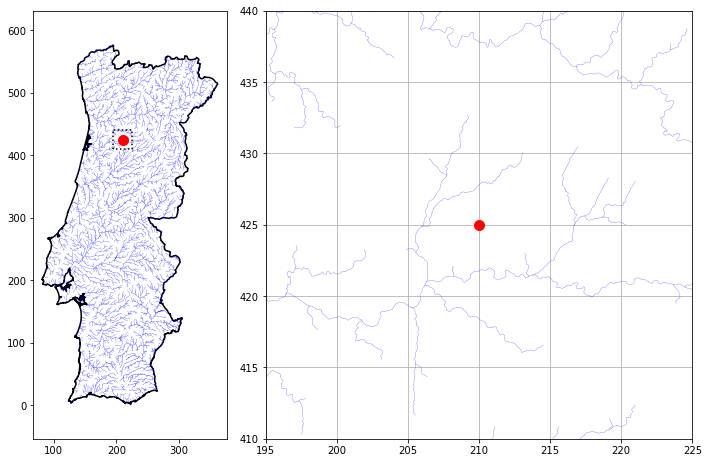

In [311]:
cm = 1/2.54  # conversão de cm para polegadas (útil para controlar o tamanho das figuras)

# Carregar mapas e outra informação vectorial
sf0 = shp.Reader('extra\portugal.shp')
sf1 = shp.Reader('extra\p_rios.shp')

fig = plt.figure(figsize=(30*cm, 20*cm)) # _ = usado para suprimir "prints"
gs = fig.add_gridspec(nrows=1, ncols=3)
ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[:, 1:])

ax0.axis('equal')
ax1.axis('equal')

# Gráfico 1:
    # Mostrar Portugal
for shape in sf0.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    _ = ax0.plot(np.array(x)/1000, np.array(y)/1000, 'k')

    # Mostrar a rede hidrográfica
for shape in sf1.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    _ = ax0.plot(np.array(x)/1000, np.array(y)/1000, 'b', lw=0.2)
    
    # Mostrar a localização da bacia
_ = ax0.plot(m,p, '.r', markersize=20)

    # Mostrar zona da bacia
margem = 15
x_zoom = [m-margem, m-margem, m+margem, m+margem, m-margem]
y_zoom = [p-margem, p+margem, p+margem, p-margem, p-margem]
ax0.plot(x_zoom, y_zoom, ':k')


# Gráfico 2:
    # Mostrar Portugal
for shape in sf0.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    _ = ax1.plot(np.array(x)/1000, np.array(y)/1000, 'k')

    # Mostrar a rede hidrográfica
for shape in sf1.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    _ = ax1.plot(np.array(x)/1000, np.array(y)/1000, 'b', lw=0.2)
    
    # Mostrar a localização da bacia
_ = ax1.plot(m,p, '.r', markersize=20)

ax1.set_xlim(min(x_zoom), max(x_zoom))
ax1.set_ylim(min(y_zoom), max(y_zoom))
ax1.grid()

### Calcular o tempo de concentração
Segundo as fórmulas de:
-  Giandotti: $t_c=\frac{4\sqrt{A}+1.5L}{0.8\sqrt{hm}}$
-  Temez: $t_c=0.3\Big(\frac{L}{dm^{0.25}}\Big)^{0.75}$
-  NERC: $t_c=2.8\Big(\frac{L}{\sqrt{d_{10:85}}}\Big)^{0.47}$
-  Kirpich: $t_c=0.95\frac{L^{1.155}}{H^{0.385}}$

As unidades de cada variável estão indicadas no acima (introduzir os dados de base).
Todas as fórmulas devolvem a estimativa do tempo de concentração em horas.

O valor a utilizar corresponde à média das estimativas anteriores.

In [312]:
# Cálculo de cada formula para tc
tcs = {} # criação de um "dict" onde as várias estimativas são guardadas
tcs['Giandotti'] = (4*area**0.5+1.5*comprimento)/(0.8*altura_media**0.5)
tcs['Temez'] = 0.3*(comprimento/(declive_medio**0.25))**0.76
tcs['NERC'] = 2.8*(comprimento/(declive_10_85)**0.5)**0.47
tcs['Kirpich'] = 0.95*(comprimento**1.155/diferenca_cotas**0.385)

tcs = pd.DataFrame(data=tcs, index=['tc [hr]']).transpose() # armazenar os dados numa tabela
tc = tcs.mean().values[0] # .values[0] é um comando interno para retirar um valor "simples" da tabela

print(tcs)
print('O valor de tc estimado é de %0.2f horas.' % tc) # %0.2f indica que se vai introduzir o valor depois to % (neste caso tc) como um "float" de duas casas décimais.



            tc [hr]
Giandotti  5.088434
Temez      5.735024
NERC       5.092874
Kirpich    3.045169
O valor de tc estimado é de 4.74 horas.


### Ilustrar a linha de possibilidade udométrica
Tendo calculado o tc, é possível estimar a precipitação de projecto para um dado período de retorno (no nosso caso 100 anos).
Para o fazer, é necessário utilizar a linha de possibilidade udométrica.

Para um período de retorno de 100 anos e um tc de 4.74 horas, a precipitação de projecto é 543.61 mm.


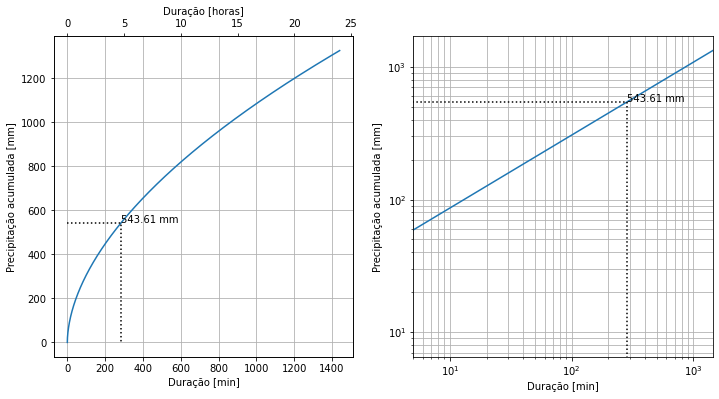

In [313]:
# Cálculo da precipitação de projecto e ilustração da linha de possibilidade udométrica

p_projecto = a*(tc*60)**n # multiplica-se por 60 para converter horas (unidades de tc) em minutos (unidades desta linha de possibilidade udométrica).
print('Para um período de retorno de 100 anos e um tc de %0.2f horas, a precipitação de projecto é %0.2f mm.' % (tc, p_projecto))

# Gráficos
    # Escala original
x = np.linspace(0, 24*60, 10000) # cria os valores x do gráfico. 10000 pontos entre 0 a 1 dias, em minutos.
p = a*x**n # aplicação da mesma fórmula a todos os x ao mesmo tempo.

fig = plt.figure(figsize=(30*cm, 15*cm))
gs = fig.add_gridspec(nrows=1, ncols=2)
ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[:, 1])

_ = ax0.plot(x, p)
ax0.set_xlabel('Duração [min]')
ax0.set_ylabel('Precipitação acumulada [mm]')

        # Anotações e estilo
ax0.plot([0, tc*60, tc*60],[p_projecto, p_projecto, 0], ':k')
ax0.annotate('%0.2f mm' % p_projecto, (tc*60, p_projecto))
ax0.grid()
        
        # Segundo eixo horizontal
ax2 = ax0.twiny()
ax2.set_xlim(ax0.get_xlim()[0]/60, ax0.get_xlim()[1]/60)
ax2.set_xlabel('Duração [horas]')

    # Escala logarítmica
_ = ax1.loglog(x, p)
ax1.set_xlabel('Duração [min]')
ax1.set_ylabel('Precipitação acumulada [mm]')

        # Anotações e estilo
ax1.plot([0, tc*60, tc*60],[p_projecto, p_projecto, 0], ':k')
ax1.annotate('%0.2f mm' % p_projecto, (tc*60, p_projecto))
ax1.grid(True, which="both")
_ = ax1.set_xlim(5, 24*60)

### Preparar hietogramas
Os hietogramas uniforme e de blocos alternados são preparados com o código seguinte.

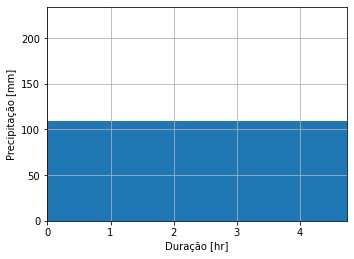

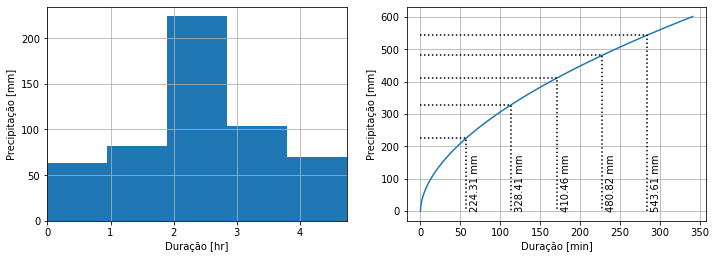

In [314]:
# Preparação do hietogramas de projecto

# Hietograma uniforme
intensidade = p_projecto/tc/60 # intensidade da precipitação [mm/min]
duracao = tc/numero_blocos*60 # minutos

fig = plt.figure(figsize=(30*cm, 10*cm))
gs = fig.add_gridspec(nrows=1, ncols=2)
ax0 = fig.add_subplot(gs[:, 0])
patch = StepPatch(edges = np.linspace(0, tc, numero_blocos+1), values=[intensidade*tc/5*60]*numero_blocos)
ax0.add_patch(patch)
ax0.set_xlim(0, tc)
ax0.set_ylim(0, a*(tc/numero_blocos*60)**n+10)

ax0.set_xlabel('Duração [hr]')
ax0.set_ylabel('Precipitação [mm]')
ax0.grid()

# Hietograma alternado
x = np.linspace(0, 6*tc/5*60, 1000) # cria os valores x do gráfico. 10000 pontos entre 0 a 1 dias, em minutos.
p = a*(x)**n # aplicação da mesma fórmula a todos os x ao mesmo tempo.

    # Obtenção dos valores para cada passo do hietograma
x_alternado = np.linspace(0, tc, numero_blocos+1)
p_alternado = a*(x_alternado*60)**n

p_diferencas = np.diff(p_alternado)
i_h_alternado = [4, 2, 0, 1, 3]
p_h_alternado = p_diferencas[i_h_alternado]


fig = plt.figure(figsize=(30*cm, 10*cm))
    # Hietograma
ax0 = fig.add_subplot(gs[:, 0])
patch = StepPatch(edges = np.linspace(0, tc, numero_blocos+1), values=p_h_alternado)
ax0.add_patch(patch)
ax0.set_xlim(0, tc)
ax0.set_ylim(0, a*(tc/numero_blocos*60)**n+10)

ax0.set_xlabel('Duração [hr]')
ax0.set_ylabel('Precipitação [mm]')
plt.grid()

    # Linha de possibilidade hidrométrica anotada
gs = fig.add_gridspec(nrows=1, ncols=2)
ax1 = fig.add_subplot(gs[:, 1])
_ = ax1.plot(x, p)
ax1.set_xlabel('Duração [min]')
ax1.set_ylabel('Precipitação [mm]')
for i0 in range(0, numero_blocos):
    ax1.plot([0, x_alternado[i0+1]*60, x_alternado[i0+1]*60],[p_alternado[i0+1], p_alternado[i0+1], 0], ':k')
    ax1.annotate('%0.2f mm' % p_alternado[i0+1], ((i0+1)*tc/5*60+5, 5), rotation=90, annotation_clip=False, textcoords='data')
plt.grid()



### Preparar o hidrograma unitário
As coordenadas do HUD introduzidas acima vão ser utilizadas para o construir. O ideal é fazer um hidrograma cujo


Hietogramas das precipitações totais
            Blocos uniformes [mm]  Blocos alternados [mm]
D Horas                                                  
1 0.948075             108.721754               62.784980
2 1.896150             108.721754               82.046540
3 2.844225             108.721754              224.312230
4 3.792300             108.721754              104.100097
5 4.740375             108.721754               70.364923

Hietogramas das precipitações efectivas
            Blocos uniformes [mm]  Blocos alternados [mm]
D Horas                                                  
1 0.948075              84.802968               48.972284
2 1.896150              84.802968               63.996302
3 2.844225              84.802968              174.963539
4 3.792300              84.802968               81.198076
5 4.740375              84.802968               54.884640


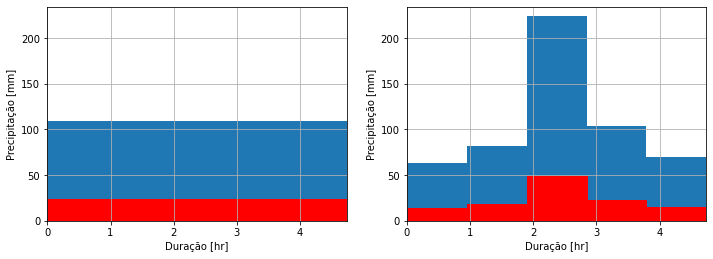

In [316]:
# Cálculo da precipitação efectiva

unidadesDeDuração = np.arange(1, numero_blocos+1)
p_h_uniforme = np.ones(numero_blocos)*intensidade*tc/5*60
p_h_alternado = p_h_alternado
hietogramas = pd.DataFrame({'Blocos uniformes [mm]': p_h_uniforme, 'Blocos alternados [mm]': p_h_alternado})
hietogramas.index = pd.MultiIndex.from_arrays([unidadesDeDuração, unidadesDeDuração*tc/5], names=('D','Horas'))
print('Hietogramas das precipitações totais')
print(hietogramas)

p_perdas = hietogramas*perdas
p_efectiva = hietogramas-p_perdas
print('')
print('Hietogramas das precipitações efectivas')
print(p_efectiva)

fig = plt.figure(figsize=(30*cm, 10*cm))
    # Hietograma uniforme
ax0 = fig.add_subplot(gs[:, 0])
patch = StepPatch(edges = np.linspace(0, tc, numero_blocos+1), values=hietogramas.loc[:, 'Blocos uniformes [mm]'])
ax0.add_patch(patch)
patch = StepPatch(edges = np.linspace(0, tc, numero_blocos+1), values=p_perdas.loc[:, 'Blocos uniformes [mm]'], color='red')
ax0.add_patch(patch)
ax0.set_xlim(0, tc)
ax0.set_ylim(0, a*(tc/numero_blocos*60)**n+10)

ax0.set_xlabel('Duração [hr]')
ax0.set_ylabel('Precipitação [mm]')
plt.grid()

    # Hietograma alternado
ax0 = fig.add_subplot(gs[:, 1])
patch = StepPatch(edges = np.linspace(0, tc, numero_blocos+1), values=hietogramas.loc[:, 'Blocos alternados [mm]'])
ax0.add_patch(patch)
patch = StepPatch(edges = np.linspace(0, tc, numero_blocos+1), values=p_perdas.loc[:, 'Blocos alternados [mm]'], color='red')
ax0.add_patch(patch)
ax0.set_xlim(0, tc)
ax0.set_ylim(0, a*(tc/numero_blocos*60)**n+10)

ax0.set_xlabel('Duração [hr]')
ax0.set_ylabel('Precipitação [mm]')
plt.grid()


### Calcular a precipitação efectiva
Para calcular a precipitação efectiva removemos as perdas (neste caso assumidas constantes). O valor das perdas já foi introduzido acima